# ML for Bioinformatics
## HW6 - Variational Autoencoder

---

Name: AmirrezaKazemi

Student No.:95105827

---
do not forget to insert your Name and Student No. in this cell !!!!

#import library and setting device

In [ ]:
!pip install torch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm, trange
%matplotlib inline

In [ ]:
device = None
######################## P0 ########################## 
# check if gpu is available then put device to cuda0 #
# else device is equal to cpu                        #
######################################################
if torch.cuda.is_available() is True:
    device = "cuda:0"
else:
    device = "cpu"

######################## end #########################

#loading Data
The MNIST database of handwritten digits contain diffrents images of digits. 

similar to MNIST,fashionMNIST is dataset containg 10 type of clothes instead of 10 type of digits. 

for example label 0 in MNIST is for 0 digit and 0 in FashionMNIST is for T-shirt. all the images is gray-scale and 28*28.

for more information you can visit this [link](https://github.com/zalandoresearch/fashion-mnist) 

In [ ]:
# Get MNIST dataloader
BATCH_SIZE = 128
data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}
train_dataset = None
test_dataset = None
train_loader = None
test_loader = None
############################## P1 ##############################
# in this cell first download the fashionMNIST dataset         #
# for train (use toTensor transform and download = True)       #
# and put it in train_dataset. then get test dataset          #
# and put it in test_dataset(no need to download again).       #
# then make train and test loader using the data_loader_kwargs #
################################################################
train_dataset = datasets.FashionMNIST("train_dataset", train=True, transform=transforms.ToTensor(), 
                                                download=True)
test_dataset = datasets.FashionMNIST("test_dataset", train=False, transform=transforms.ToTensor(), 
                                                download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

######################## end #########################


Extracting train_dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to train_dataset/FashionMNIST/raw


Extracting train_dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to train_dataset/FashionMNIST/raw


Extracting train_dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to train_dataset/FashionMNIST/raw


Extracting train_dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to train_dataset/FashionMNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting test_dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to test_dataset/FashionMNIST/raw


Extracting test_dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to test_dataset/FashionMNIST/raw


Extracting test_dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to test_dataset/FashionMNIST/raw


Extracting test_dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to test_dataset/FashionMNIST/raw
Processing...
Done!


#Auto-Encoder

In [ ]:
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()
        # input_dim = is the dimension of your input
        # encoder_dims = is list containing of some integer that shows the dimension of encoder layers, between input layer and latent layer  
        # z_dim = dimension of latent layer
        # decoder_dims = is list containing of some integer that shows the dimension of decoder layers, between latent layer and output layer (same as input_dim)  
        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        encoder_layers = list()
        ####################### P2 ###############################
        # Iterate over `encoder_dims` and create fully connected #
        # layers using nn.Linear. Use ReLU activation function   #   
        # after each FC layer using nn.ReLU Append all layers to #
        #`encoder_layers`.                                       #
        ##########################################################
        all_enc_dims = encoder_dims
        all_enc_dims.insert(0, input_dim)
        for i in range(len(all_enc_dims) - 1):
            encoder_layers.append(nn.Linear(all_enc_dims[i], all_enc_dims[i+1]))
            encoder_layers.append(nn.ReLU())
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ########################  P3 #############################
        # Define a fully connected layer that maps the output of #
        # previous part to `z_dim` dimensions, store it in       #
        # `self.z_layer`. No activation function is needed after #
        # this layer.                                            #
        ##########################################################
        self.z_layer = nn.Linear(all_enc_dims[-1], self.z_dim)
        ######################## End #############################

        # Decoder part
        decoder_layers = list()
        ########################## P4 ###############################
        # Define the decoder part (Use `decoder_dims`)              #
        # Use ReLU activation function after each FC layer          # 
        # (except the last one).The last layer output should be     #
        # of `input_dim` size. Append all layers to `decoder_layers`#
        #############################################################
        all_dec_dims = decoder_dims
        all_dec_dims.insert(0, self.z_dim)
        for i in range(len(all_dec_dims) - 1):
            decoder_layers.append(nn.Linear(all_dec_dims[i], all_dec_dims[i+1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(all_dec_dims[-1], input_dim))
        
        ####################### End ##################################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ P5 #######################
        # Do the forward pass                     #
        # use dropped_out instead of x            #
        # Compute `x_hat` (reconstructed inputs), #
        # and `z` (the latent variables)          #
        ###########################################
        temp = self.encoder(dropped_out)
        z = self.z_layer(temp)
        x_hat = self.decoder(z)
        ####################### End ###############
        return x_hat, z, None 

    def get_loss(self, x, x_hat, *_):
        ########### P6 ############
        # Compute and return the  #
        # MSE between x and x_hat #
        ###########################  
        return ((x_hat - x)**2).mean()
        ########### End ###########

# train and test functions
in the following cells we enumerate on datasets and on each batch, first we flatten 28*28 image to 784 and then giving this to forward pass of our model. then by computing loss and running backprop on loss we can have all the gradients. then by calling optimizer.step() we update all the parameters.
in test function we find loss and report that.


In [ ]:
LOG_INTERVAL = 200
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))
    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [ ]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [ ]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    LEARNING_RATE = 5e-5
    ###################### P7 ################################
    # Send `model` to the desired device, defined in `device`#
    ##########################################################
    torch.cuda.set_device(device)
    model.cuda()
    ####################### End ##############################

    optimizer = None
    ################## P8 #####################
    # Initialize a new Adam optimizer         #
    ###########################################
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    ################## End ####################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

In [ ]:
#run this cell to train model and report loss on test dataset
ae = AE(28*28, [512,128,64], 30, [64,128,512])
run(ae,40)


Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0003

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001



In [ ]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)
    ########################### P9 #############################
    # calculate the #cols that we need and then plot images in #
    # appropriate #cols and #rows                              #
    ############################################################
    n_images = images.shape[0]
    n_cols = n_images // rows
    fig = plt.figure(figsize=(28, 28))
    for i in range(1, n_cols*rows +1):
      fig.add_subplot()
      fig.add_subplot(rows, n_cols, i)
      plt.imshow(images[i-1])
    plt.show()

    ############################ end ###########################

#VAE
now similar to auto encoder we want to make class that inherit from AE class and implement VAE

In [ ]:
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)
        
        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ############################# P10 #############################
        # Define mu and logvar layers                                 #
        # Notice that we should have a logvar_layer, not a sigma_layer#
        # Do not use any activation function                          #
        ###############################################################
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        ############################## End ############################

    @staticmethod
    def reparameterize(mu, logvar):
        z = None
        ############################### P11 #################################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can#
        # backpropagate through this sampling operation                     #
        #####################################################################
        eps = torch.normal(0, 1, size=list(mu.size()), device=device)
        z = mu + logvar.exp() * eps

        ############################### End ##################################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################################# P12 ####################################
        # Do the forward pass                                                    #
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of #
        # `mu_layer` and `logvar_layer` respectively)                            #
        # Use reparameterization trick (the function you have implemented)       #
        ##########################################################################
        temp = self.encoder(dropped_out)
        mu = self.mu_layer(temp)
        logvar = self.logvar_layer(temp)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        ################################### End ###################################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################################## P13 ######################################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder      #
        # output)
                                                                           #
        #############################################################################
        MSE = F.mse_loss(x, x_hat)
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu*mu - torch.exp(logvar), dim = 1)) / 786.0
        ################################## End ######################################
        return (MSE + KLD)

    def generate(self, n):
        samples = None
        ################################## P14 ##################################
        # Generate `n` random noises from N(0, I), feed it into the decoder and #
        # generate `n` samples                                                  #
        #########################################################################
        noise = np.random.normal(0, 1, n)
        samples = self.decoder(noise)
        ################################### End #################################
        return samples

#Training VAE
using the functions from last part we can train our VAE model and see the loss on train and test datasets

In [ ]:
vae = VAE(28*28, [512,128,64], 30, [64,128,512])
run(vae,40)


Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00061
    Train [51072/60000]	 | 	Loss: 0.00064
==> Train | Average loss: 0.0007
==> Test  | Average loss: 0.0006

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00045
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0004

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00040
    Train [51072/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00040
    Train [51072/60000]	 | 	Loss: 0.00041
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0003

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00026
    Train [51072/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00026
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00024
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002



Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


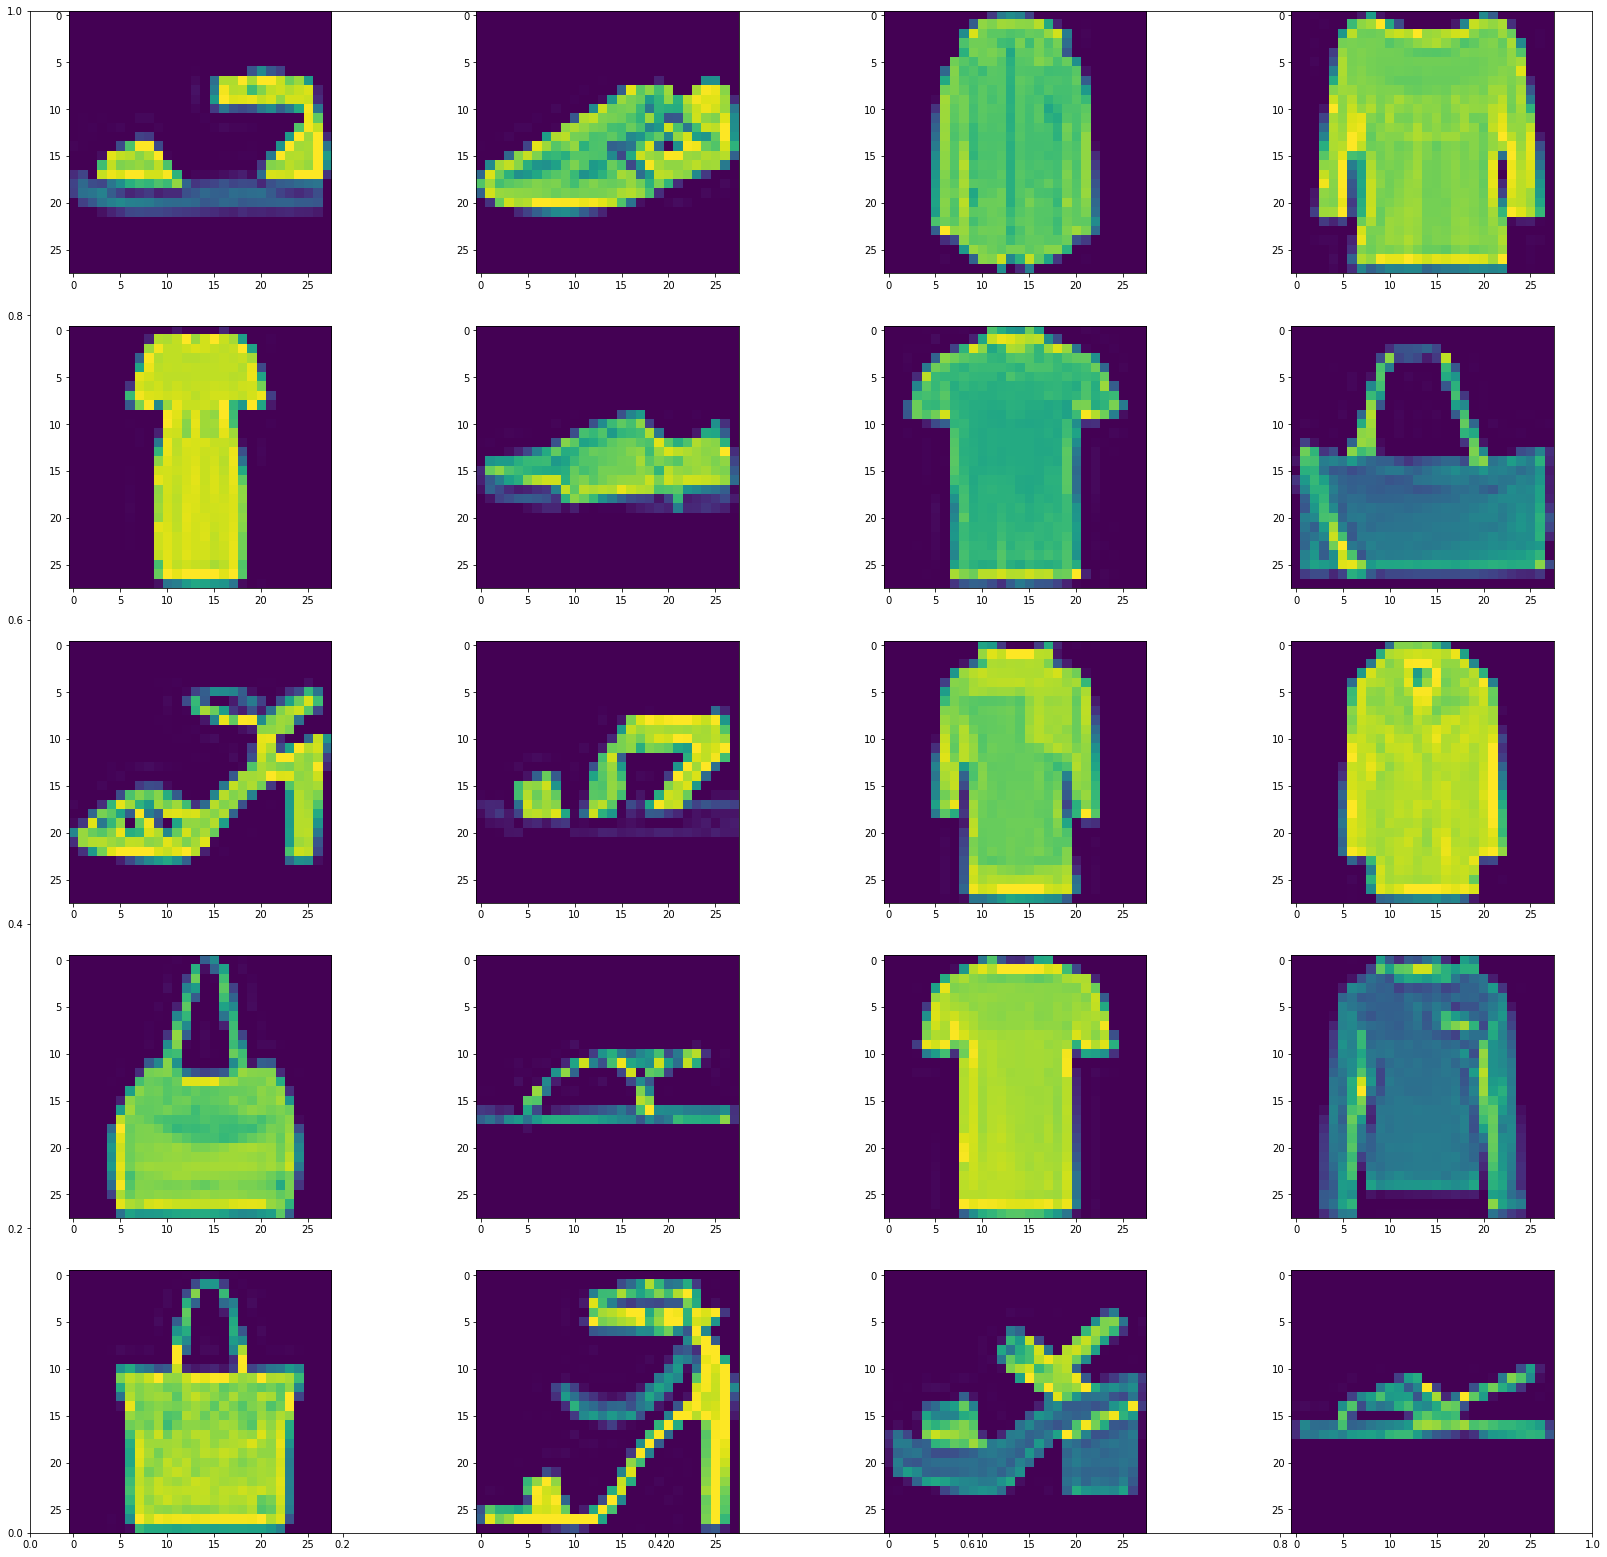

AE 30D


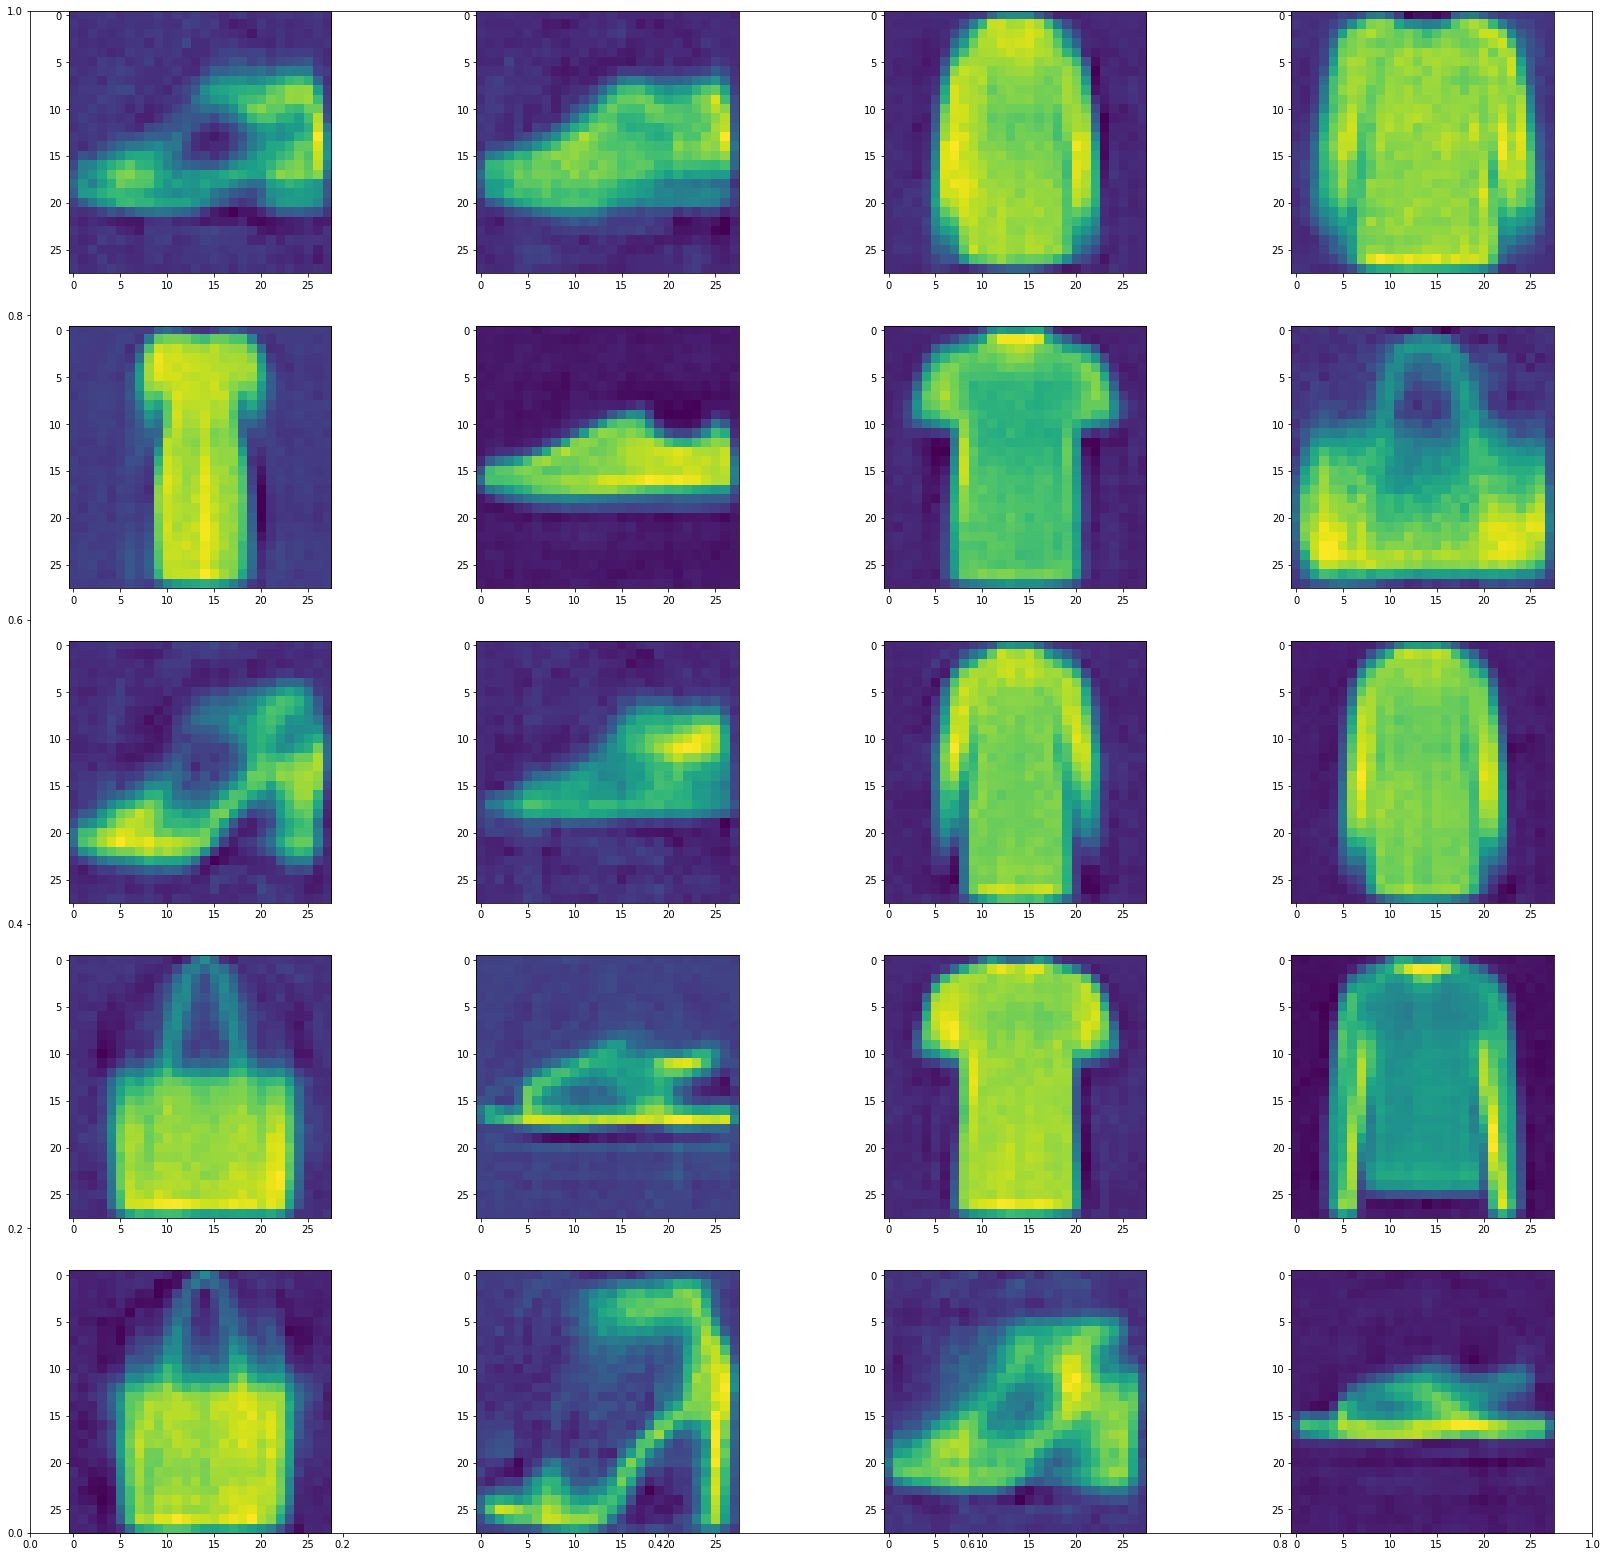

VAE 30D


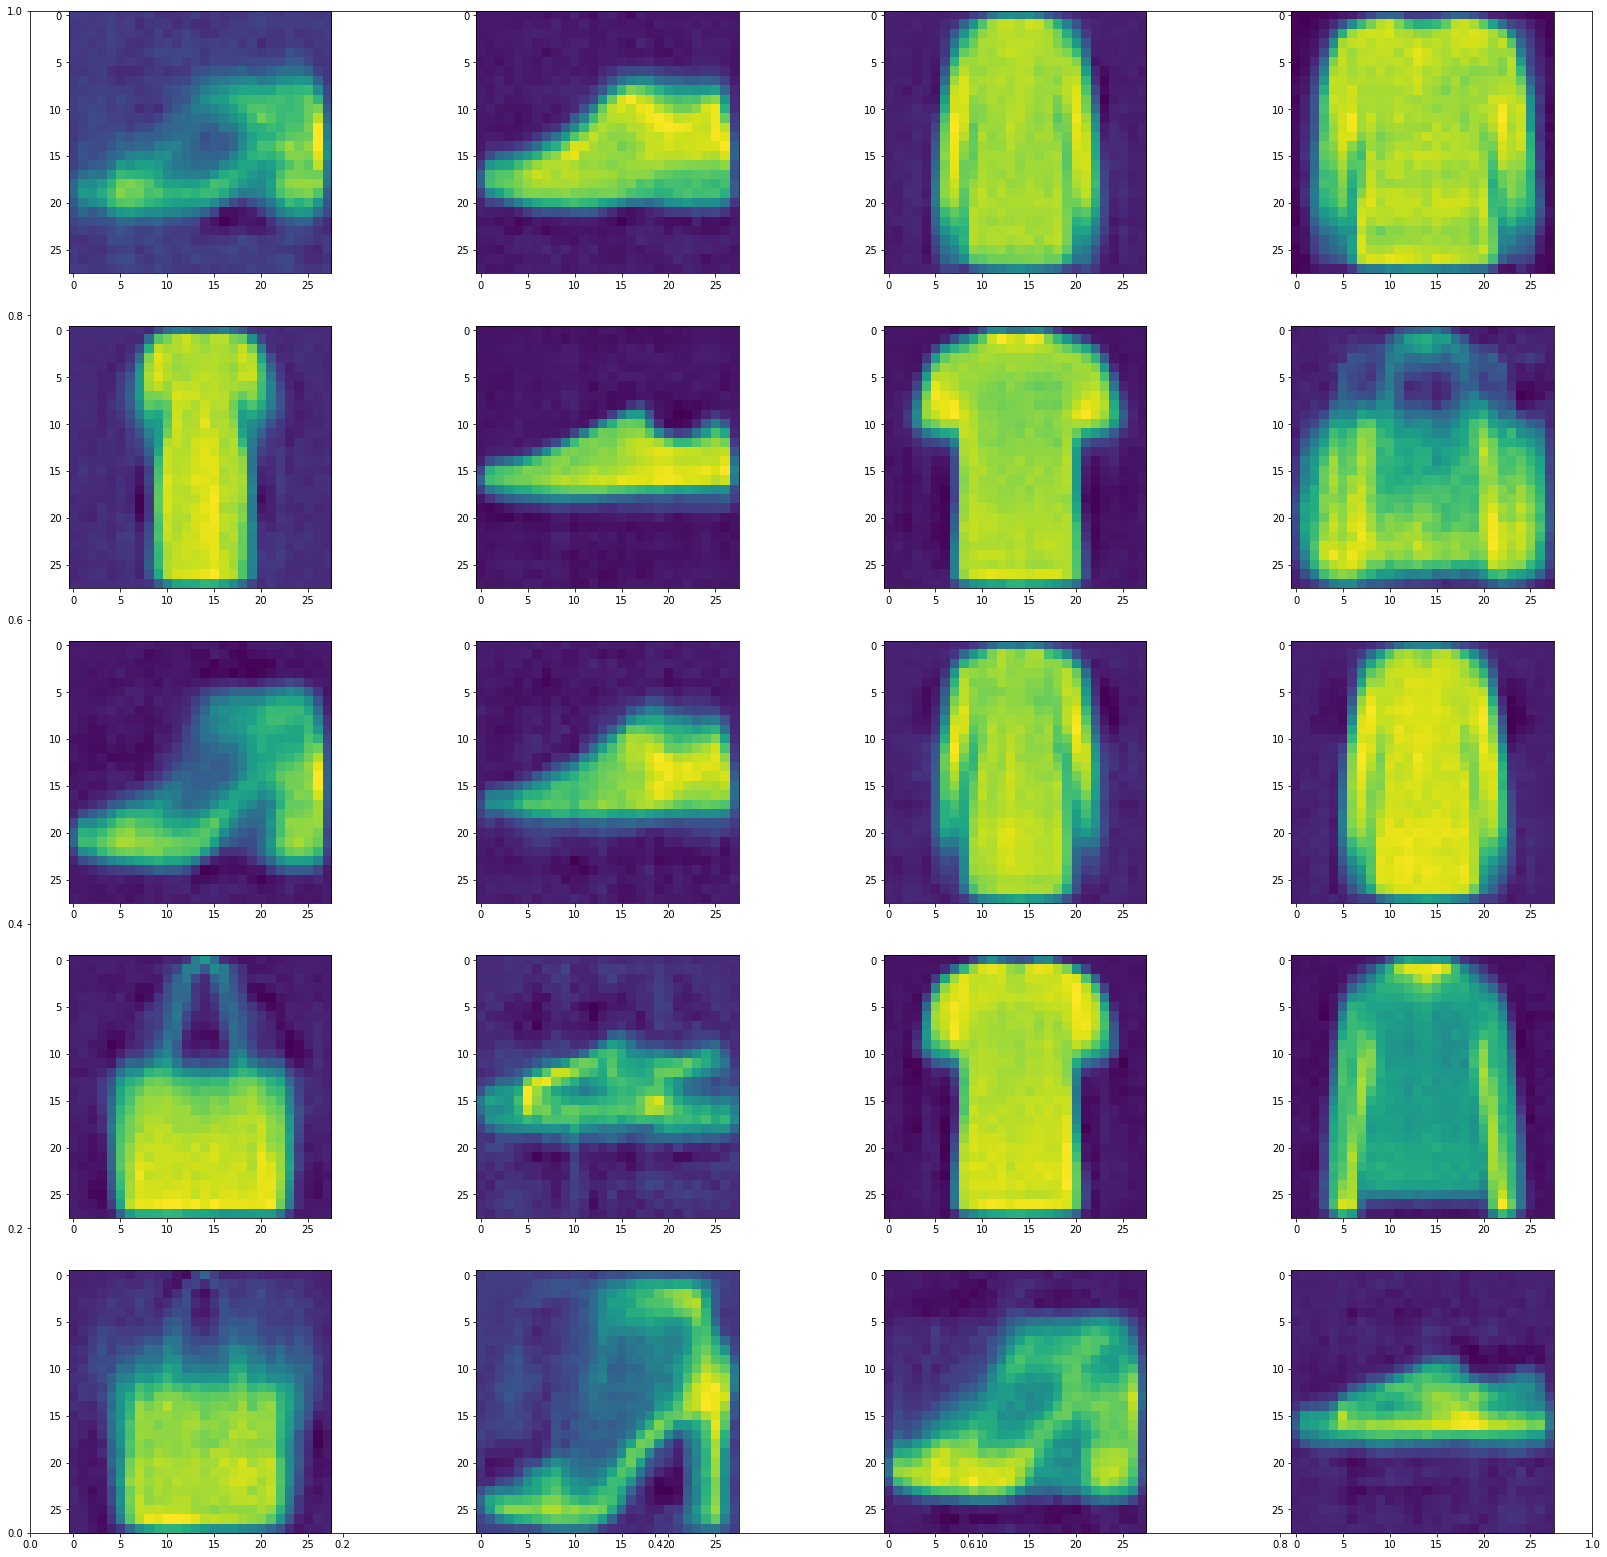

In [ ]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1), rows=5)

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu(), rows=5)
models = [ae,vae]
plot_reconstructions(models, 20)

#interpolation part1
now we want to produce first image that has new features. there is probablity that these features even not exist in train dataset. in this part we want to find the mean of some trouser images in z space and then find mean of some shirt image in z space. then add this means together and give this new z to decoder. we expect that we have Tshirt that has trouser on it.
this is so usefull. consider some images of some faces. mean all the faces that has smile on theire faces and similar thing to all faces that has no smile. then subtract no smile mean in z space from smile faces in z-space. this work gives you the smile in z space. so you can add this smile to every face and make angry face to happy face !!

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!












Data



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


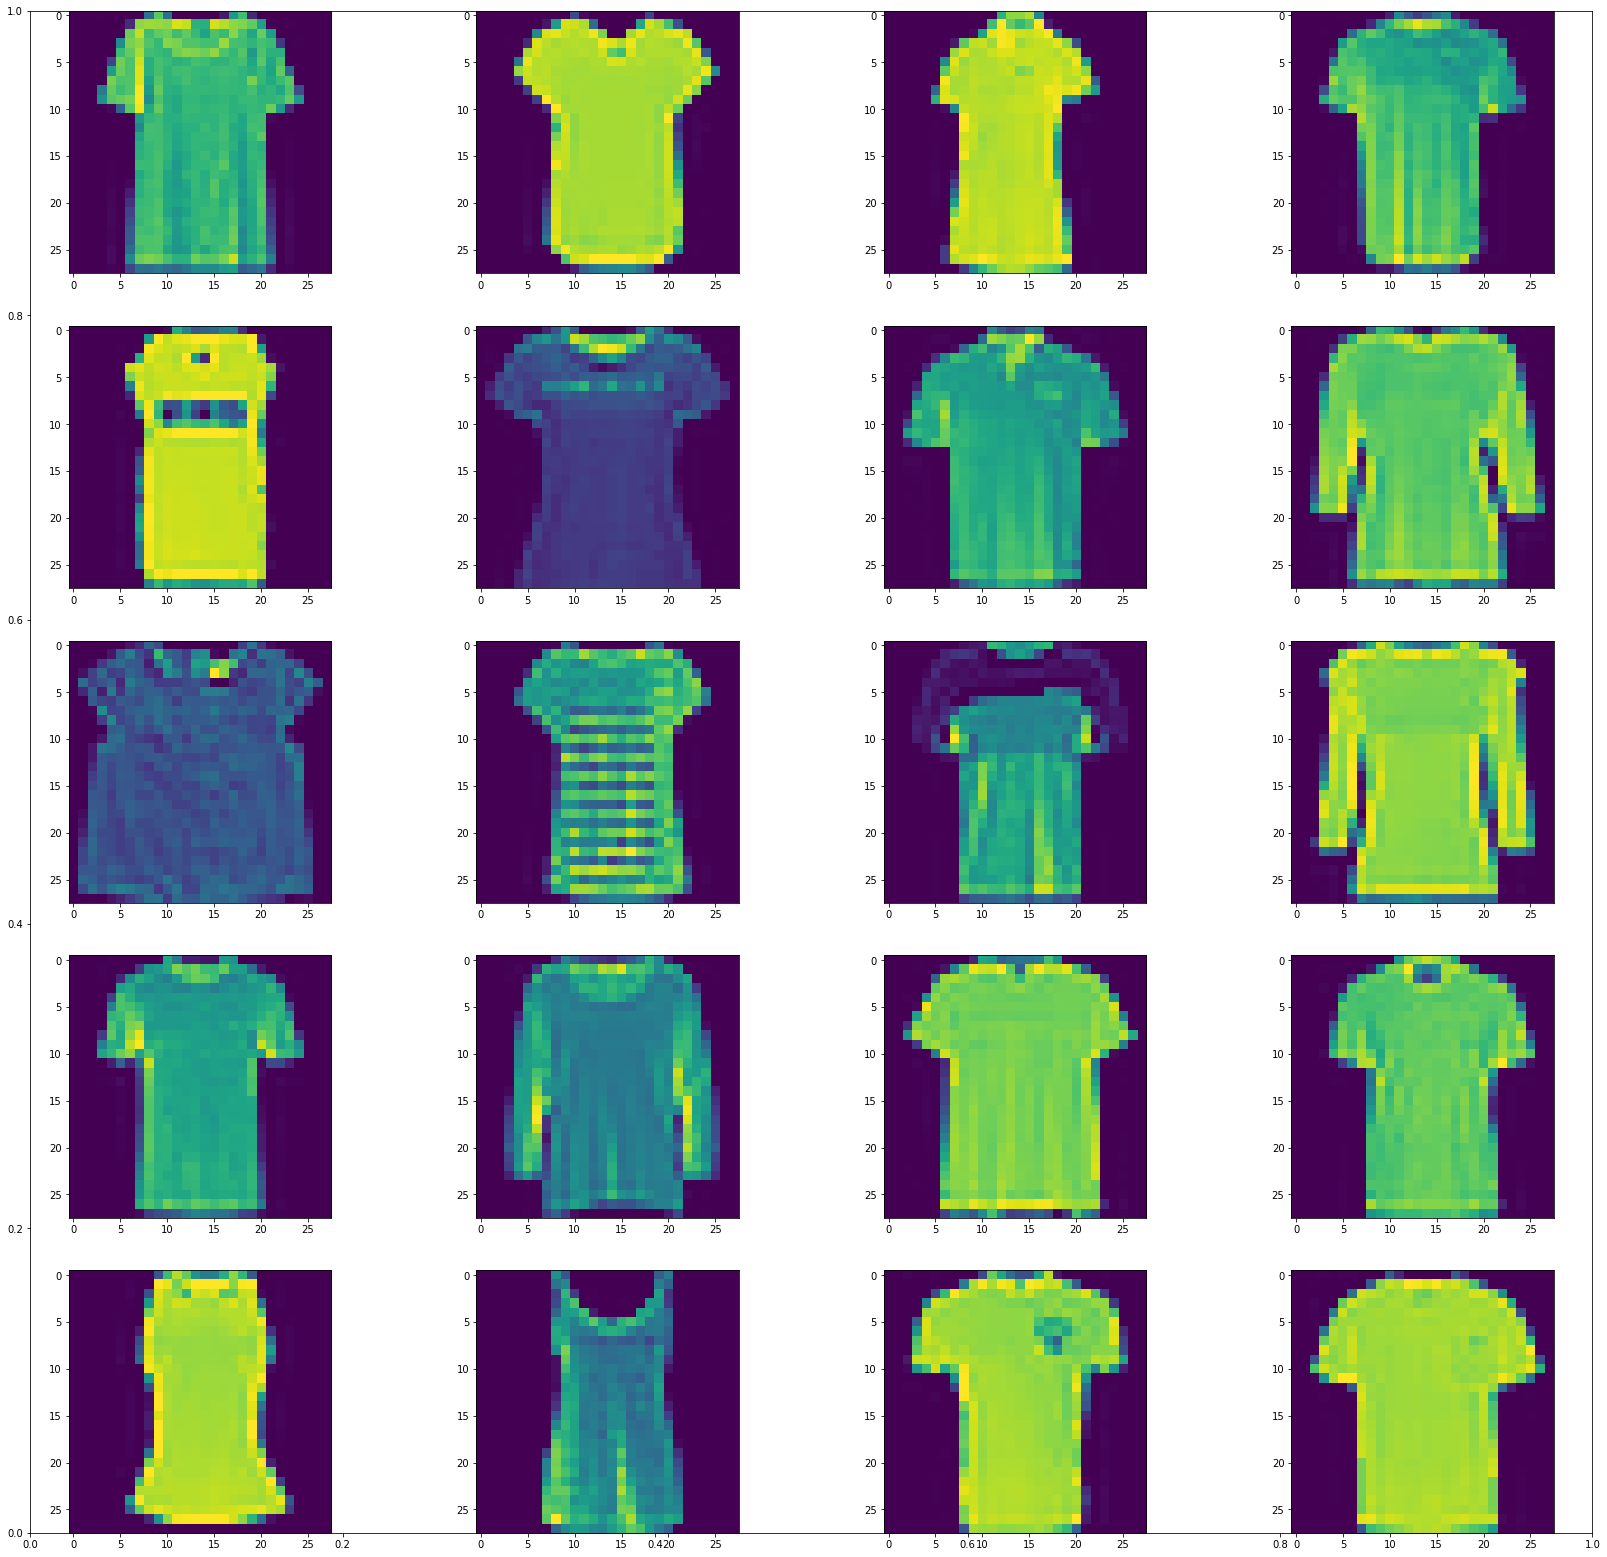

Data


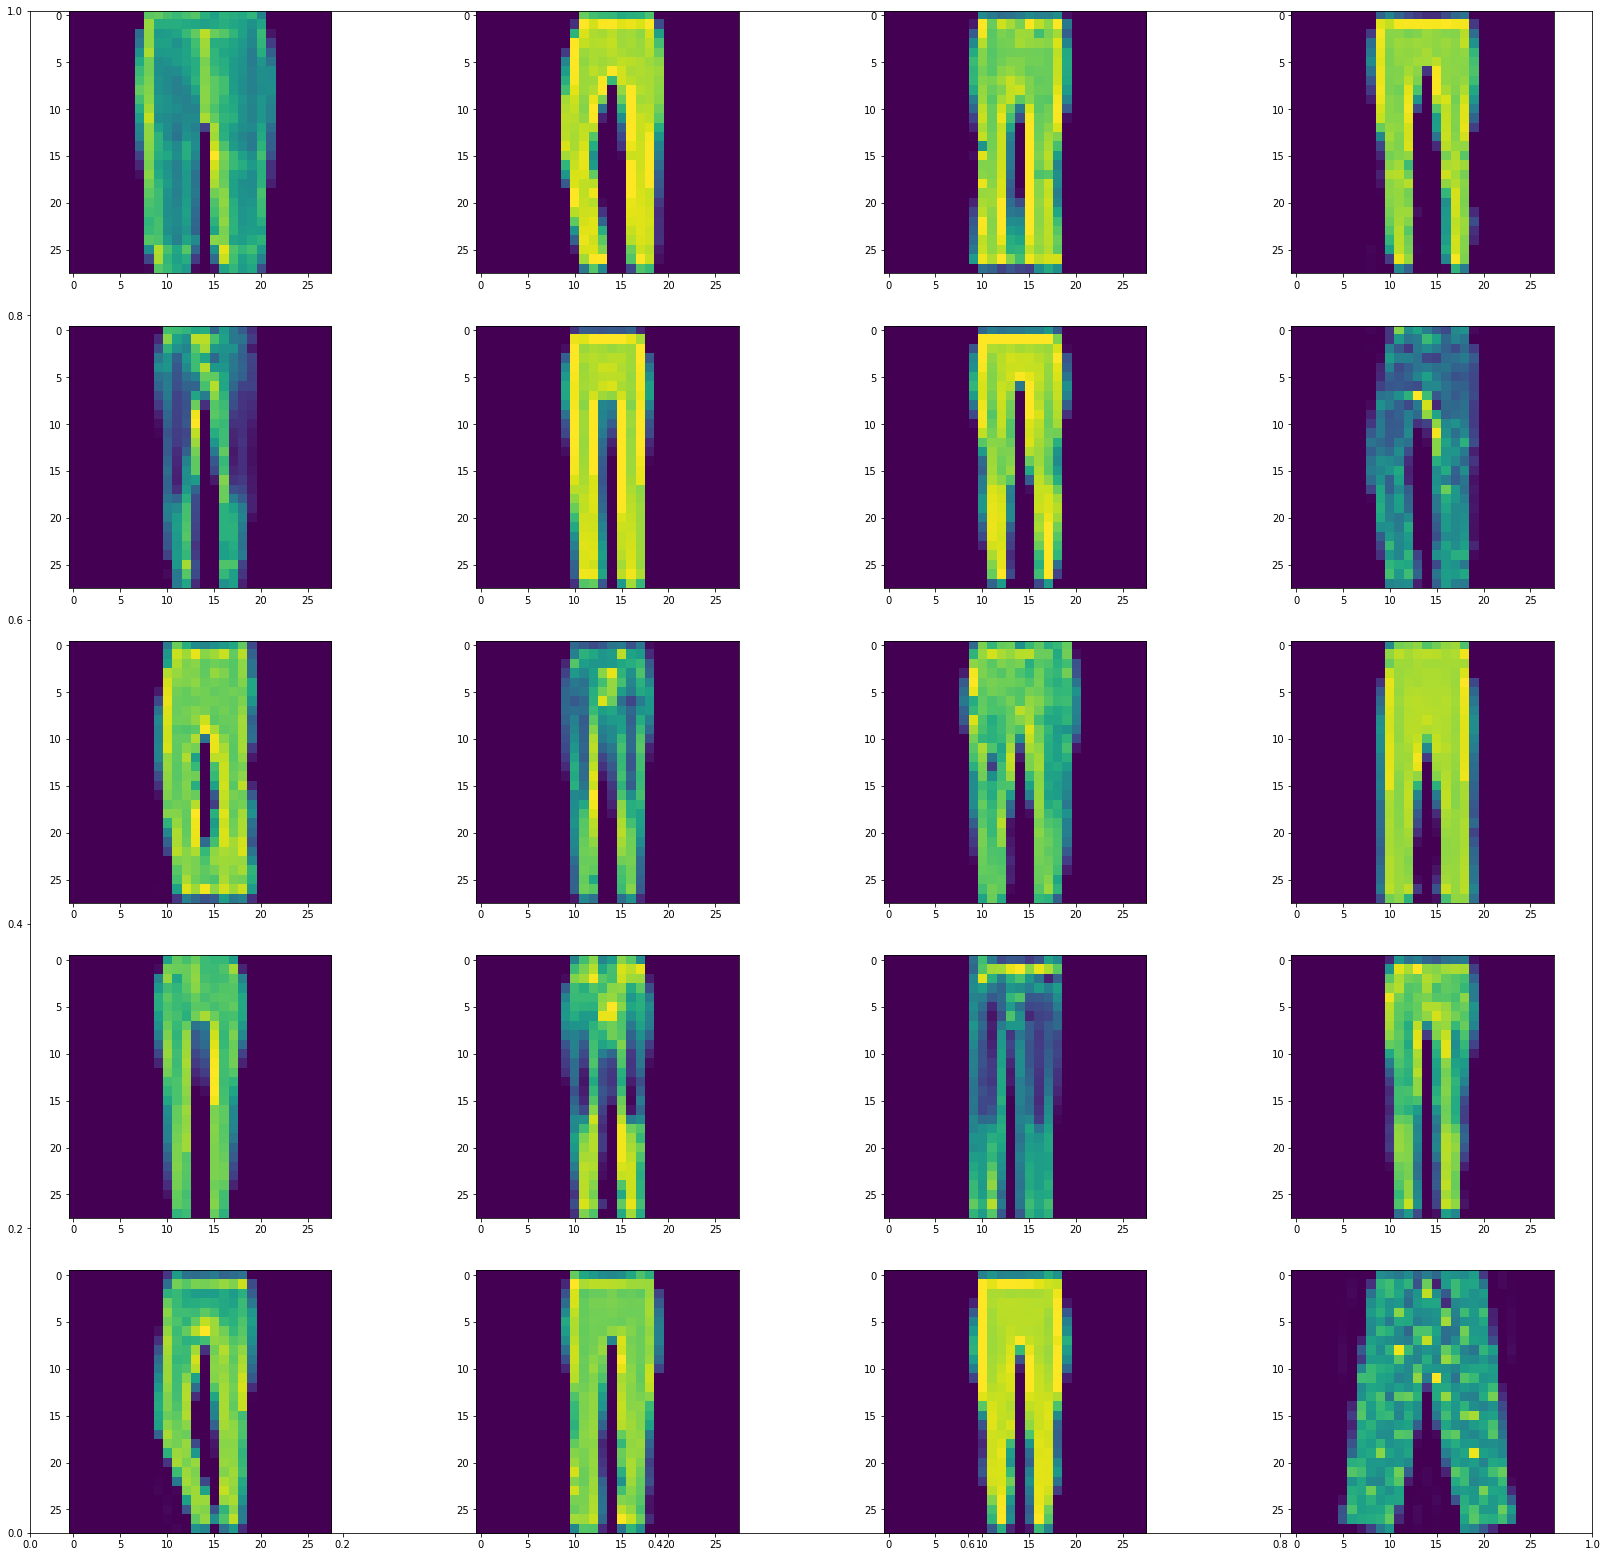

In [ ]:
train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 0
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_trouser = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_trouser))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1), rows = 5)

train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 1
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_shirts = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_shirts))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1), rows = 5)

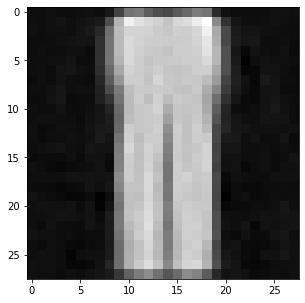

In [ ]:
def combine(model, n_rows):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (5, 5)
    x = next(iter(test_loader_trouser))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    y = next(iter(test_loader_shirts))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    shirt_with_trouser = None
    ########################## P15 ###############################
    # use x , y and find mean of trousers and Tshirts in z space #
    # then add theme together in z space and store this value    #
    # in shirt_with_trouser                                      #
    ########################## end ###############################
    dropped_out1 = model.dropout(x)
    temp1 = model.encoder(dropped_out1)
    mu1 = model.mu_layer(temp1)
    logvar1 = model.logvar_layer(temp1)
    z1 = model.reparameterize(mu1, logvar1)
    trouser_mean = torch.mean(z1, dim =0)

    dropped_out2 = model.dropout(y)
    temp2 = model.encoder(dropped_out2)
    mu2 = model.mu_layer(temp2)
    logvar2 = model.logvar_layer(temp2)
    z2 = model.reparameterize(mu2, logvar2)
    shirt_mean = torch.mean(z2, dim = 0)

    shirt_with_trouser = shirt_mean + trouser_mean
    ######################### end ##############################
    img = model.decoder(shirt_with_trouser).cpu().detach()
    img = img.reshape(-1, 28, 28)
    plt.imshow(img[0],cmap = "gray")
    #show(img, 10)
vae = vae.to(device)
combine(vae, 128)

#interpolations part 2


In [ ]:
def plot_interpolations(model, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        model.eval()
        images = list()
        ################################ P16 #####################################
        # give your images(img1,img2) to model and get latent value for each     #
        # images.call them z1 and z2. then in z dimension space split the line   #
        # distance between z1 and z2,into n_cols and start to move from z1 to z2 #
        # and find n_cols point between z1 and z2 (in z_dim space). then use     #
        # decoder for new points in z_space and get new image for each point.    #
        # first append img1 to images list then append all new image that        #
        # decoders produced and then append img2 at the end of list.             #
        ##########################################################################
        if type(model) is AE:
            dropped_out1 = model.dropout(img1)
            temp1 = model.encoder(dropped_out1)
            z1 = model.z_layer(temp1)

            dropped_out2 = model.dropout(img2)
            temp2 = model.encoder(dropped_out2)
            z2 = model.z_layer(temp2)
        else:
            dropped_out1 = model.dropout(img1)
            temp1 = model.encoder(dropped_out1)
            mu1 = model.mu_layer(temp1)
            logvar1 = model.logvar_layer(temp1)
            z1 = model.reparameterize(mu1, logvar1) 
            
            dropped_out2 = model.dropout(img2)
            temp2 = model.encoder(dropped_out2)
            mu2 = model.mu_layer(temp2)
            logvar2 = model.logvar_layer(temp2)
            z2 = model.reparameterize(mu2, logvar2)

        dif = z2 - z1

        for j in range(n_cols+1):
            newz = z1 + j/n_cols * dif
            newimg = model.decoder(newz).cpu().detach()
            images.append(newimg)

        
        ################################ end #####################################
        images = torch.stack(images)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(images, rows=5)
    print('---\n')
plot_interpolations(ae, 3)
plot_interpolations(vae, 3)